#### Presence absence analysis of the DK0911 genome based on orthology



#### Usefull folders

- Warrior TE analysis: /home/benjamin/genome_assembly/Warrior/TE_analysis
- Pst_104_TE analysis: /home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/Warrior_comp_runs/REPET/TE_analysis
- comparative coverage: /home/benjamin/genome_assembly/Warrior/TE_analysis


In [1]:
%matplotlib inline

In [2]:
import os
from pybedtools import BedTool
import pandas as pd
import scipy
import pandas as pd
import numpy as np # need for  stats
import matplotlib.pyplot as plt
import seaborn as sns
import re
from scipy.stats import mannwhitneyu
from scipy.stats import fisher_exact
from scipy.stats import spearmanr
from scipy.stats import wilcoxon
from scipy.stats import kruskal
from statsmodels.stats.multitest import multipletests
from seaborn import boxenplot
import pybedtools

In [3]:
DK0911_ortho_dir = '/home/benjamin/genome_assembly/Warrior/DK0911_v04/comp_orthology/orthofinder/DK0911_vs_Ps104E_v13/'
Pst_104E_ortho_dir = '/home/benjamin/genome_assembly/Warrior/DK0911_v04/comp_orthology/orthofinder/Ps104E_v13_vs_DK0911/'
DK0911_genome_file_fn = '/home/benjamin/genome_assembly/Warrior/genome_v04/DK_0911_v04_ph_ctg.genome_file'
Pst_104E_genome_file_fn = \
'/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/092017_assembly/Pst_104E_v13_ph_ctg.genome_file'
WGA_PAA_dir = '/home/benjamin/genome_assembly/Warrior/DK0911_v04/comp_COV/mummer4'
LOWCOV_PAA_dir = '/home/benjamin/genome_assembly/Warrior/DK0911_v04/comp_COV/SRM_mapping/filtered/'
ORTHOFINDER_FILE_NAME = '/home/benjamin/genome_assembly/Warrior/DK0911_v04/comp_orthology/orthofinder/result_update_redundant_protein_sets_01032019/Orthogroups_3_combined.csv'
OUT_dir = '/home/benjamin/genome_assembly/Warrior/DK0911_v04/comp_orthology/orthofinder/downstream_analysis/'
ORTHOFINDER_FILE_NAME = '/home/benjamin/genome_assembly/Warrior/DK0911_v04/comp_orthology/orthofinder/result_update_redundant_protein_sets_01032019/Orthogroups_3_combined.csv'

* do simple checks if any of the genes is more likely to lack orthologs then others e.g. BUSCOS vs effectors and such
* check if the missing orthologs overlap with other missing genes
* pull in the Synet file for synteny and ask if effectors are in longer blogs or ask what is the speciatly of shorter blogs or now hits


In [4]:
###all the bedfiles
Pst_104E_annotation_dir = '/home/benjamin/genome_assembly/Warrior/DK0911_v04/comp_orthology/Pst104E_annotations/'
Pst_104E_dict = {}
Pst_104E_dict['Busco'] = os.path.join(Pst_104E_annotation_dir, 'Pst_104E_v13_ph_ctg.busco.gene.bed')
Pst_104E_dict['All_genes'] = os.path.join(Pst_104E_annotation_dir, 'Pst_104E_v13_ph_ctg.genes.gene.bed')
Pst_104E_dict['Primary_genes'] = os.path.join(Pst_104E_annotation_dir, 'Pst_104E_v13_p_ctg.genes.gene.bed')
Pst_104E_dict['Secretome'] = os.path.join(Pst_104E_annotation_dir, 'Pst_104E_v13_ph_ctg.secretome.gene.bed')
Pst_104E_dict['Ceffectors'] = os.path.join(Pst_104E_annotation_dir, 'Pst_104E_v13_ph_ctg.ceffectors.gene.bed')
Pst_104E_dict['EffectorP'] = os.path.join(Pst_104E_annotation_dir, 'Pst_104E_v13_ph_ctg.effectorp.gene.bed')
Pst_104E_dict['TE_superfamily'] = os.path.join(Pst_104E_annotation_dir, 'Pst_104E_v13_ph_ctg.104Ep_DK0911p.REPET.superfamily.gff')
Pst_104E_dict['Lowcov_01'] = os.path.join(LOWCOV_PAA_dir, 'Pst_104E_v13_ph_ctg.bwamem.DK0911_gDNA.ph_window_w1000s200.ph_mapping.lowcov01.filtered.bed')
Pst_104E_dict['WGA_95'] = os.path.join(WGA_PAA_dir, 'Pst_104E_v13_ph_ctg.DK_0911_v04_ph_ctg.l100.c500.mm.deltafilter_i95mu0g_.nr_reverse.bed')
Pst_104E_dict['Singletons'] = os.path.join(Pst_104E_ortho_dir,'190312_Ps104E_v13_vs_DK0911_singleton.csv')
Pst_104E_dict['Alleles'] = os.path.join(Pst_104E_ortho_dir, '190312_Ps104E_v13_vs_DK0911_allele.csv')
Pst_104E_dict['Paraloges'] = os.path.join(Pst_104E_ortho_dir, '190312_Ps104E_v13_vs_DK0911_paraloge.csv')

In [5]:
###all the bedfiles
DK0911_annotation_dir = '/home/benjamin/genome_assembly/Warrior/DK0911_v04/comp_orthology/DK0911_annotations/'
DK0911_dict = {}
DK0911_dict['Busco'] = os.path.join(DK0911_annotation_dir, 'DK_0911_v04_ph_ctg.busco.gene.bed')
DK0911_dict['All_genes'] = os.path.join(DK0911_annotation_dir, 'DK_0911_v04_ph_ctg.genes.gene.bed')
DK0911_dict['Primary_genes'] = os.path.join(DK0911_annotation_dir, 'DK_0911_v04_p_ctg.genes.gene.bed')
DK0911_dict['Secretome'] = os.path.join(DK0911_annotation_dir, 'DK_0911_v04_ph_ctg.secretome.gene.bed')
DK0911_dict['Ceffectors'] = os.path.join(DK0911_annotation_dir, 'DK_0911_v04_ph_ctg.effectorp20.gene.bed')
DK0911_dict['EffectorP'] = os.path.join(DK0911_annotation_dir, 'DK_0911_v04_ph_ctg.effectorp20.gene.bed')
DK0911_dict['TE_superfamily'] = os.path.join(DK0911_annotation_dir, 'DK_0911_v04_ph_ctg.104Ep_DK0911p.REPET.superfamily.gff')
DK0911_dict['Lowcov_01'] = os.path.join(LOWCOV_PAA_dir, 'DK_0911_v04_ph_ctg.bwamem.Pst79_TS.RG.mark_dup.ph_window_w1000s200.ph_mapping.lowcov01.filtered.bed' )
DK0911_dict['WGA_95'] = os.path.join(WGA_PAA_dir, 'DK_0911_v04_ph_ctg.Pst_104E_v13_ph_ctg.l100.c500.mm.deltafilter_i95mu0g_.nr_reverse.bed')
DK0911_dict['Singletons'] = os.path.join(DK0911_ortho_dir,'190506_DK0911_vs_Ps104E_v13_singleton.csv')
DK0911_dict['Alleles'] = os.path.join(DK0911_ortho_dir, '190506_DK0911_vs_Ps104E_v13_allele.csv')
DK0911_dict['Paraloges'] = os.path.join(DK0911_ortho_dir, '190506_DK0911_vs_Ps104E_v13_paraloge.csv')

In [70]:
##OUTPATH for figures
OUTPATH='/home/benjamin/genome_assembly/Warrior/DK0911_v04/figures'

In [6]:
def overlap_feature_names(bed_a_fn, bed_b_fn, min_f_overlap):
    """Count the number of unqiue genes that intersect witht basence bedfile.
    Assumes bed_a_fn is a bed six file."""
    bed_a = BedTool(bed_a_fn)
    bed_b = BedTool(bed_b_fn)
    return bed_a.intersect(bed_b, f=min_f_overlap).to_dataframe().name.unique()

In [7]:
def get_sing_para(fn):
    if 'singleton' in fn:
        return pd.read_csv(fn)['Query'].tolist()
    elif 'paraloge' in fn:
        queries = pd.read_csv(fn)['Query'].tolist()
        targets = pd.read_csv(fn)['Target'].tolist()
        return queries, targets
    else:
        raise ValueError

In [8]:
def get_gene_list(bed_fn):
    df = pd.read_csv(bed_fn, header=None, sep='\t')
    return df[3].unique()

In [9]:
def subset_bed(name_list, bed_fn, out_fn):
    df = pd.read_csv(bed_fn, header=None, sep='\t')
    df[df[3].isin(name_list)].to_csv(out_fn, sep='\t', header=None, index=None)
    return out_fn

In [10]:
def random_genes(bed_fn, n):
    df = pd.read_csv(bed_fn, header=None, sep='\t')
    return df.sample(n)[3].tolist()

In [11]:
def fisher_p(test_list, expect_list):
    return fisher_exact([[len(test_list[0]), len(test_list[1])], [len(expect_list[0]), len(expect_list[1])]])[1]

In [12]:
def count_genes_in_bed(bed_fn):
    return pd.read_csv(bed_fn, header=None, sep='\t').shape[0]

In [13]:
def summary_dict_to_df(summary_dict, outer_index, inner_index):
    """Convert as summary dict with multiple keys and values of same length. To a multiindex dataframe."""
    assert(outer_index[0:int(len(outer_index)/2)] == outer_index[int(len(outer_index)/2):])
    assert(inner_index[0:int(len(inner_index)/2)] == inner_index[int(len(inner_index)/2):])
    df = pd.DataFrame.from_dict(summary_dict)
    df['Cut_off'] = [x for x in outer_index[0:int(len(outer_index)/2)]]
    
    df['Type'] = inner_index[0:int(len(inner_index)/2)]
    df.sort_values(['Cut_off', 'Type'], inplace = True)
    index = pd.MultiIndex.from_tuples(list(zip(df['Cut_off'] , df['Type'])), names=['Cut-off', 'Type'])
    df.index = index
    return df.loc[:, df.columns[:2]].copy()

In [125]:
def plot_synteny(genome, df,filter_bed_fn,color, out_fn):
   
    columns = [x for x in df.columns if genome in x][1:]
    
    f1, ax = plt.subplots(1, len(columns), figsize=(20, 7), sharey=True)
    
    column_rename_dict = {'All_genes': 'All genes',
                         'Busco': "BUSCOs",
                         'Ceffectors': 'Candidate effectors',
                         'EffectorP' : 'EffectorP',
                         'Secretome' : 'Secretome'}
    
    for n, column in enumerate(columns):
        if genome == 'DK0911':
            _dict = DK0911_dict
        elif genome =='Pst_104E':
            _dict = Pst_104E_dict
        sub_gene_list = get_gene_list(filter_bed_fn)
        df = df[df[genome].isin(sub_gene_list)].copy()
        df = df.reset_index(drop=True)    
        max_genes = len([x for x in get_gene_list(_dict[column.replace(genome+'_','')]) if x in sub_gene_list])
        
        
        sns.violinplot(y=df[df[column] == True]['aln_length'], color=color, ax=ax[n], cut =0)
        #ax[y[0], y[1]].axhline(y=overlap, color='r', linestyle='-')
        #ax[n].set_title(column, fontsize=16)
        #ax[y[0], y[1]].set_yticklabels([])
        ax[n].set_ylabel('')
        ax[n].set_xlabel(column_rename_dict[column.replace(genome+"_",'')]\
                         , fontsize=20, fontweight='bold')
        ax[n].text(0.1, 390, 'n=%s' % df[df[column] == True].shape[0])
        
        
        
        ax[n].text(0.1, 370, 'max=%s' % max_genes)
        percentage = round(df[df[column] == True].shape[0]/max_genes*100,2)
        ax[n].text(0.1, 350, '%%=%s' % percentage)
        for axis in ['bottom','left']:
            ax[n].spines[axis].set_linewidth(2)
        for axis in ['top','right']:
            ax[n].spines[axis].set_linewidth(0)
        ax[n].tick_params(width=2)
        
    ax[0].set_ylabel('Synteny Block Size', fontsize=20, fontweight='bold')
    ax[0].set_ylim(0, 400)
    plt.subplots_adjust(right=0.3, left=0.1)
    #f1.suptitle(genome)
    plt.tight_layout()
    #f1.suptitle(os.path.basename(out_fn))
    #plt.savefig(out_fn, dpi =300)
    sns.despine(f1)
    return f1

In [15]:
def get_collinear_df(fn):
    """Parses out a dataframe from a collinear file obtained with synet runs.
    This is not universial right now but assumes that DK0911 is first in this file and Pst104 is
    second in this file."""

    synteny_dict = {}
    synteny_dict['aln_name'] = []
    synteny_dict['aln_position'] = []
    synteny_dict['aln_length'] = []
    synteny_dict['Pst_104E'] = []
    synteny_dict['DK0911'] = []
    synteny_dict['distance_5'] = []
    synteny_dict['distance_3'] = []
    len_pattern = re.compile(r'N=([^ ]*)')
    d_pattern = re.compile(r'DK[^\t]*')
    p_pattern = re.compile(r'Pst[^\t]*')
    position_pattern = re.compile(r'-([^:]*)')
    count = 0
    with open(fn, 'r') as fh:
        for line in fh:
            line.rstrip()
            count = count + 1
            if line.startswith(r'## '):
                aln_len = int(re.findall(len_pattern, line)[0])
                aln_name = line.split(':')[0][3:]
            elif not line.startswith(r'#'):
                aln_position = int(re.findall(position_pattern , line)[0].replace(' ', ''))
                synteny_dict['DK0911'].append(re.findall(d_pattern, line)[0])
                synteny_dict['Pst_104E'].append(re.findall(p_pattern, line)[0])
                synteny_dict['aln_name'].append(aln_name)
                synteny_dict['aln_length'].append(aln_len)
                synteny_dict['aln_position'].append(aln_position)
                synteny_dict['distance_5'].append(aln_position)
                synteny_dict['distance_3'].append(aln_len - aln_position)
    syn_df = pd.DataFrame.from_dict(synteny_dict)
    return syn_df


In [16]:
def get_diamond_six_df(fn):
    header = ['qseqid',
 'sseqid',
 'pident',
 'length',
 'mismatch',
 'gapopen',
 'qstart',
 'qend',
 'sstart',
 'send',
 'evalue',
 'bitscore']
    return pd.read_csv(fn, header=None, sep='\t', names=header)

In [17]:
def add_gentype_column(df, gene_type_list, genome, bed_fn_dict):
    """A function that takes a collinear dataframe, a gentype list, a genome name and a dictionary
    that contains the filenames for bedfiles of genes belonging to different genetypes.
    The function adds a new column to the df with False/True to belonging to the genetype."""
    for gene_type in gene_type_list:
        tmp_index = df[genome].isin(get_gene_list(bed_fn_dict[gene_type]))
        key = '%s_%s' % (genome, gene_type)
        df[key] = False
        df.loc[tmp_index, key] = True
    return df

In [18]:
def get_genetype_means(df, genome, gene_keys):
    means = []
    for gene_type in gene_keys:
        column = '%s_%s' % (genome, gene_type)
        means.append(round(df[df[column] == True]['aln_length'].mean(),2))
    return means

In [19]:
def get_genetype_median(df, genome, gene_keys):
    medians = []
    for gene_type in gene_keys:
        column = '%s_%s' % (genome, gene_type)
        medians.append(round(df[df[column] == True]['aln_length'].median(),2))
    return medians

In [20]:
def get_genetype_percentage(df, genome, bed_fn_dict, subset_bed_fn, gene_keys):
    percentages = []
    for gene_type in gene_keys:
        column = '%s_%s' % (genome, gene_type)
        max_genes = set(get_gene_list(bed_fn_dict[gene_type])).intersection(get_gene_list(subset_bed_fn))
        percentages.append(round(len(df[df[column] == True][genome].unique())/len(max_genes)*100,2))
        
    return percentages

In [21]:
def max_colinear_df(_dict, gene_keys):
    df = pd.DataFrame.from_dict(_dict)
    df.index = gene_keys
    new_columns = [int(x) for x in df.columns]
    new_columns.sort()
    new_columns = [str(x) for x in new_columns]
    return df.loc[:, new_columns].copy()

In [22]:
def get_ortho_dict(file_name):
    """Function that takes a orthofinder file name and generates an orthofinder dict.
    Input:
        CSV Filename of orthofinder output.
    Output:
        Orthofinder dict with keys intergers of the numerical part of the orthofinder group.
        Values are the gene identifier of each orthogroup."""
    orthofinder_dict = {}
    try:
        with open(file_name) as fh:
            for line in fh:
                if line.startswith('OG'):
                    line.strip()
                    OG = line.split('\t')[0]
                    value = [x.strip() for x in line.split(OG)[1].replace('\t',',').split(',') if x != '']
                    orthofinder_dict[int(line.split('\t')[0].strip('OG'))] = value
        return orthofinder_dict
    except FileNotFoundError:
        print("Please check the orthofinder in put file.")

In [23]:
def get_gene_to_ortho_dict(orthofinder_dict):
    """Function that makes a gene to ortho dict."""
    gene_to_ortho_dict = {}
    for key,value in orthofinder_dict.items():
        for item in value:
            gene_to_ortho_dict[item] = key
    return gene_to_ortho_dict

#### Start with a chek if all two inputs of orhtology and ben beds line up

In [24]:
DK_all = get_gene_list(DK0911_dict['All_genes'])
Pst_104_all = get_gene_list(Pst_104E_dict['All_genes'])

In [25]:
set(DK_all) == (set(pd.read_csv(DK0911_dict['Alleles'], header=None)[1][1:].unique())\
| set(get_sing_para(DK0911_dict['Paraloges'])[0]) | set(get_sing_para(DK0911_dict['Singletons']))) 

True

In [26]:
set(Pst_104_all) == (set(pd.read_csv(Pst_104E_dict['Alleles'], header=None)[1][1:].unique())\
| set(get_sing_para(Pst_104E_dict['Paraloges'])[0]) | set(get_sing_para(Pst_104E_dict['Singletons']))) 

True

In [27]:
#get the combined missing genes and test if the overlap is significant with a fishers exact test and randomization
min_overlap = 1
key = "WGA_LOWCOV_combined_mo%s" % str(min_overlap).replace('.','')

for _dict in [DK0911_dict, Pst_104E_dict]:
    WGA_genes = overlap_feature_names(_dict['All_genes'], _dict['WGA_95'], min_overlap)
    WGA_random = random_genes(_dict['All_genes'], len(WGA_genes))
    LOWCOV_genes = overlap_feature_names(_dict['All_genes'], _dict['Lowcov_01'], min_overlap)
    LOWCOV_random = random_genes(_dict['All_genes'], len(LOWCOV_genes))
    genome = os.path.basename(_dict['All_genes']).split('.')[0]
    overlap_list = [x for x in WGA_genes if x in LOWCOV_genes]
    random_overlap_list = [x for x in WGA_random if x in LOWCOV_random]
    out_fn = os.path.join(OUT_dir, '%s.%s.bed' % (genome, key))
    _dict[key] = subset_bed(overlap_list, _dict['All_genes'], out_fn)
    p_WGA = fisher_p([overlap_list, WGA_genes],[random_overlap_list, WGA_genes] )
    p_LOWCOV = fisher_p([overlap_list, LOWCOV_genes],[random_overlap_list, LOWCOV_genes] )
    print('For %s:\nWGA_missing:%s, %.2E\nLOWCOV_missing:%s, %.2E\nCombined_missing:%s\nRandom_missing:%s\n'%\
         (genome, len(WGA_genes), p_WGA,  len(LOWCOV_genes), p_LOWCOV, len(overlap_list), len(random_overlap_list)))

For DK_0911_v04_ph_ctg:
WGA_missing:553, 1.42E-34
LOWCOV_missing:724, 2.30E-35
Combined_missing:185
Random_missing:14

For Pst_104E_v13_ph_ctg:
WGA_missing:2084, 3.40E-182
LOWCOV_missing:2394, 5.88E-188
Combined_missing:1441
Random_missing:184



In [28]:
for _dict in [DK0911_dict, Pst_104E_dict]:
    WGA_genes = overlap_feature_names(_dict['All_genes'], _dict['WGA_95'], min_overlap)
    WGA_random = random_genes(_dict['All_genes'], len(WGA_genes))
    singletons = get_sing_para(_dict['Singletons'])
    singletons_random = random_genes(_dict['All_genes'], len(singletons))
    genome = os.path.basename(_dict['All_genes']).split('.')[0]
    overlap_list = [x for x in WGA_genes if x in singletons]
    random_overlap_list = [x for x in WGA_random if x in singletons_random]
    
    p_WGA = fisher_p([overlap_list, WGA_genes],[random_overlap_list, WGA_genes] )
    p_sing = fisher_p([overlap_list, singletons],[random_overlap_list, singletons] )
    print('For %s:\nWGA_missing:%s, %.2E\nSingletons_missing:%s, %.2E\nCombined_missing:%s\nRandom_missing:%s\n'%\
         (genome, len(WGA_genes), p_WGA,  len(singletons), p_sing, len(overlap_list), len(random_overlap_list)))



For DK_0911_v04_ph_ctg:
WGA_missing:553, 1.60E-13
Singletons_missing:1275, 2.37E-14
Combined_missing:133
Random_missing:34

For Pst_104E_v13_ph_ctg:
WGA_missing:2084, 1.94E-34
Singletons_missing:1404, 4.84E-33
Combined_missing:345
Random_missing:87



In [29]:
for _dict in [DK0911_dict, Pst_104E_dict]:
    WGA_genes = overlap_feature_names(_dict['All_genes'], _dict['WGA_95'], min_overlap)
    WGA_random = random_genes(_dict['All_genes'], len(WGA_genes))
    singletons = get_sing_para(_dict['Singletons'])
    singletons_random = random_genes(_dict['All_genes'], len(singletons))
    genome = os.path.basename(_dict['All_genes']).split('.')[0]
    LOWCOV_genes = overlap_feature_names(_dict['All_genes'], _dict['Lowcov_01'], min_overlap)
    LOWCOV_random = random_genes(_dict['All_genes'], len(LOWCOV_genes))
    
    overlap_list = [x for x in WGA_genes if x in singletons and x in LOWCOV_genes]
    random_overlap_list = [x for x in WGA_random if x in singletons_random and LOWCOV_random]
    
    p_WGA = fisher_p([overlap_list, WGA_genes],[random_overlap_list, WGA_genes] )
    p_sing = fisher_p([overlap_list, singletons],[random_overlap_list, singletons] )
    p_LOWCOV = fisher_p([overlap_list, LOWCOV_genes],[random_overlap_list, LOWCOV_genes] )
    print('For %s:\nWGA_missing:%s, %.2E\nSingletons_missing:%s, %.2E\nLOWCOV_missing:%s, %.E2\nCombined_missing:%s\nRandom_missing:%s\n'%\
         (genome, len(WGA_genes), p_WGA,  len(singletons), p_sing, len(LOWCOV_genes), p_LOWCOV,  len(overlap_list), len(random_overlap_list)))

For DK_0911_v04_ph_ctg:
WGA_missing:553, 1.07E-04
Singletons_missing:1275, 5.71E-05
LOWCOV_missing:724, 8E-052
Combined_missing:55
Random_missing:20

For Pst_104E_v13_ph_ctg:
WGA_missing:2084, 5.35E-22
Singletons_missing:1404, 2.64E-21
LOWCOV_missing:2394, 3E-222
Combined_missing:276
Random_missing:88



In [30]:
#numbers of overlaps in missing` vs. gene category and the states (as before)
Fishers_summary_dict = {}
Absence_summary_dict = {}
outer_index = [] #being the cut off
inner_index = [] #being the type of gene to look at
Fishers_summary_dict['DK0911'] = []
Fishers_summary_dict['Pst_104E'] = []
Absence_summary_dict['DK0911'] = []
Absence_summary_dict['Pst_104E'] = []
min_overlap = 1
key = ''
gene_keys = ['All_genes','Busco', 'Ceffectors',  'EffectorP',   'Secretome']
missing_keys = ['Lowcov_01', 'WGA_95',  'WGA_LOWCOV_combined_mo1',]

for _dict in [DK0911_dict, Pst_104E_dict]:
    for gene_key in gene_keys:
        for missing_key in missing_keys:
        
            inner_index.append(missing_key)
            outer_index.append(gene_key)
            category_genes_missing = overlap_feature_names(_dict[gene_key], _dict[missing_key], min_overlap)
            all_genes_missing = overlap_feature_names(_dict['All_genes'], _dict[missing_key], min_overlap)
            p_value = fisher_exact([[len(category_genes_missing), count_genes_in_bed(_dict[gene_key])],\
                              [len(all_genes_missing), count_genes_in_bed(_dict['All_genes'])]])[1]
            percent_lost = round(len(category_genes_missing)/count_genes_in_bed(_dict[gene_key])*100, 2)
            absence_value = [len(category_genes_missing), count_genes_in_bed(_dict[gene_key]), percent_lost]
            if os.path.basename(_dict['All_genes']).startswith('DK'):
                key = 'DK0911'
            elif os.path.basename(_dict['All_genes']).startswith('Pst_104'):
                key = 'Pst_104E'
            
            Fishers_summary_dict[key].append(p_value)
            Absence_summary_dict[key].append(absence_value)

In [31]:
Fishers_df = summary_dict_to_df(Fishers_summary_dict, outer_index, inner_index)
Absence_df = summary_dict_to_df(Absence_summary_dict, outer_index, inner_index)

In [32]:
Fishers_df

DK0911      Pst_104E
Cut-off    Type                                               
All_genes  Lowcov_01                1.000000e+00  1.000000e+00
           WGA_95                   1.000000e+00  1.000000e+00
           WGA_LOWCOV_combined_mo1  1.000000e+00  1.000000e+00
Busco      Lowcov_01                2.108868e-12  5.455648e-10
           WGA_95                   4.579768e-05  1.324495e-13
           WGA_LOWCOV_combined_mo1  1.477667e-03  9.379411e-17
Ceffectors Lowcov_01                3.326542e-02  5.836811e-02
           WGA_95                   9.235022e-01  3.479875e-03
           WGA_LOWCOV_combined_mo1  7.400221e-01  5.795804e-03
EffectorP  Lowcov_01                3.326542e-02  4.923270e-02
           WGA_95                   9.235022e-01  5.003802e-01
           WGA_LOWCOV_combined_mo1  7.400221e-01  7.886652e-01
Secretome  Lowcov_01                1.436367e-06  5.983996e-02
           WGA_95                   1.839260e-02  2.438171e-03
           WGA_LOWCOV_combined_mo1  1.750980e-02  6.937300e-05

In [33]:
Absence_df 

DK0911             Pst_104E
Cut-off    Type                                                            
All_genes  Lowcov_01                [724, 25940, 2.79]  [2394, 30249, 7.91]
           WGA_95                   [553, 25940, 2.13]  [2084, 30249, 6.89]
           WGA_LOWCOV_combined_mo1  [185, 25940, 0.71]  [1441, 30249, 4.76]
Busco      Lowcov_01                   [13, 2178, 0.6]     [126, 2740, 4.6]
           WGA_95                     [20, 2178, 0.92]     [91, 2740, 3.32]
           WGA_LOWCOV_combined_mo1     [4, 2178, 0.18]     [44, 2740, 1.61]
Ceffectors Lowcov_01                  [25, 1376, 1.82]    [244, 3520, 6.93]
           WGA_95                     [28, 1376, 2.03]    [194, 3520, 5.51]
           WGA_LOWCOV_combined_mo1     [8, 1376, 0.58]    [130, 3520, 3.69]
EffectorP  Lowcov_01                  [25, 1376, 1.82]    [189, 2038, 9.27]
           WGA_95                     [28, 1376, 2.03]    [149, 2038, 7.31]
           WGA_LOWCOV_combined_mo1     [8, 1376, 0.58]    [100, 2038, 4.91]
Secretome  Lowcov_01                  [55, 3699, 1.49]    [327, 4637, 7.05]
           WGA_95                     [57, 3699, 1.54]    [261, 4637, 5.63]
           WGA_LOWCOV_combined_mo1    [14, 3699, 0.38]    [159, 4637, 3.43]

In [34]:
#comparing number of genes in category with overlap in singletons
#get the combined missing genes and test if the overlap is significant with a fishers exact test and randomization

min_overlap = 1
key = ''
missing_dict = {}
fisher_dict = {}
missing_dict['DK0911'] = []
missing_dict['Pst_104E'] = []
fisher_dict['DK0911'] = []
fisher_dict['Pst_104E'] = []
gene_keys = ['All_genes','Busco', 'Ceffectors',  'EffectorP',   'Secretome']
for _dict in [DK0911_dict, Pst_104E_dict]:
    for gene_key in gene_keys:    
        category_genes = overlap_feature_names(_dict['All_genes'], _dict[gene_key], min_overlap)
        all_genes = overlap_feature_names(_dict['All_genes'], _dict['All_genes'], min_overlap)
        singletons = get_sing_para(_dict['Singletons'])
            
        all_genes_overlap = [x for x in all_genes if x in singletons]
        
            
        catetory_genes_overlap = [x for x in category_genes if x in singletons]
               
        p_value = fisher_p([ catetory_genes_overlap, category_genes],[all_genes_overlap, all_genes])
        absence_value = [len(catetory_genes_overlap), len(category_genes), len(singletons)]
        percent_lost = len(catetory_genes_overlap)/len(category_genes) *100
        if os.path.basename(_dict['All_genes']).startswith('DK'):
            genome = 'DK0911'
        elif os.path.basename(_dict['All_genes']).startswith('Pst_104'):
            genome = 'Pst_104E'
        missing_dict[genome].append(absence_value[0])
        fisher_dict[genome].append(p_value)
            
        print('For %s:\n%s:%s, %.2E, %.2f'%\
         (genome, gene_key, absence_value,  p_value, percent_lost)) 
            
 

For DK0911:
All_genes:[1275, 25940, 1275], 1.00E+00, 4.92
For DK0911:
Busco:[7, 2178, 1275], 5.91E-34, 0.32
For DK0911:
Ceffectors:[53, 1376, 1275], 9.31E-02, 3.85
For DK0911:
EffectorP:[53, 1376, 1275], 9.31E-02, 3.85
For DK0911:
Secretome:[109, 3699, 1275], 9.30E-08, 2.95
For Pst_104E:
All_genes:[1404, 30249, 1404], 1.00E+00, 4.64
For Pst_104E:
Busco:[17, 2740, 1404], 1.06E-31, 0.62
For Pst_104E:
Ceffectors:[153, 2960, 1404], 2.20E-01, 5.17
For Pst_104E:
EffectorP:[142, 2038, 1404], 2.07E-05, 6.97
For Pst_104E:
Secretome:[190, 4637, 1404], 1.21E-01, 4.10


In [35]:
df_missing = pd.DataFrame.from_dict(missing_dict)
df_missing.index = gene_keys
df_missing

,DK0911,Pst_104E
All_genes,1275,1404
Busco,7,17
Ceffectors,53,153
EffectorP,53,142
Secretome,109,190


In [36]:
df_fisher = pd.DataFrame.from_dict(fisher_dict)
df_fisher.index = gene_keys
df_fisher

,DK0911,Pst_104E
All_genes,1.000000e+00,1.000000e+00
Busco,5.906117e-34,1.059775e-31
Ceffectors,9.305928e-02,2.200546e-01
EffectorP,9.305928e-02,2.069424e-05
Secretome,9.297606e-08,1.211186e-01


In [37]:
syn_net_base_folder = '/home/benjamin/genome_assembly/Warrior/DK0911_v04/comp_orthology/run_SynNet/'
syn_net_files = [os.path.join(syn_net_base_folder, x, 'DK_PAu.collinearity') for x in os.listdir(syn_net_base_folder) if x.startswith('Genomes')]

In [38]:
for x in syn_net_files:
    print(x)
    print(os.path.exists(x))

/home/benjamin/genome_assembly/Warrior/DK0911_v04/comp_orthology/run_SynNet/Genomes20190514_1113-SynNet-k25w0m3/DK_PAu.collinearity
True
/home/benjamin/genome_assembly/Warrior/DK0911_v04/comp_orthology/run_SynNet/Genomes20190514_1247-SynNet-k25w0m8/DK_PAu.collinearity
True
/home/benjamin/genome_assembly/Warrior/DK0911_v04/comp_orthology/run_SynNet/Genomes20190514_1016-SynNet-k25w0m0/DK_PAu.collinearity
True
/home/benjamin/genome_assembly/Warrior/DK0911_v04/comp_orthology/run_SynNet/Genomes20190514_1036-SynNet-k25w0m1/DK_PAu.collinearity
True
/home/benjamin/genome_assembly/Warrior/DK0911_v04/comp_orthology/run_SynNet/Genomes20190514_1149-SynNet-k25w0m5/DK_PAu.collinearity
True
/home/benjamin/genome_assembly/Warrior/DK0911_v04/comp_orthology/run_SynNet/Genomes20190514_1227-SynNet-k25w0m7/DK_PAu.collinearity
True
/home/benjamin/genome_assembly/Warrior/DK0911_v04/comp_orthology/run_SynNet/Genomes20190514_1054-SynNet-k25w0m2/DK_PAu.collinearity
True
/home/benjamin/genome_assembly/Warrior/DK

want to get for each gene the position in the alignement, the length of the alignment, the alignement name, plus its match.


In [39]:
collinear_df_dict = {}
for fn in syn_net_files:
    collinear_df_dict[fn.split('/')[-2]] = get_collinear_df(fn)

In [40]:
gene_keys = ['All_genes','Busco', 'Ceffectors',  'EffectorP',   'Secretome']
for key, value in collinear_df_dict.items():
    for genome, bed_fn_dict in zip(['DK0911', 'Pst_104E'], [DK0911_dict, Pst_104E_dict]):
        collinear_df_dict[key] = add_gentype_column(value, gene_keys, genome, bed_fn_dict)

In [41]:
#a dataframe that contains multiindex columns (genomes and m values) as columns, gentypes as rows
#and values are lists of maximal collinear blocks per gene. Lose the linkage between geneid and block length

In [42]:
max_collinear_df_dict = {}
for key, tmp_df in collinear_df_dict.items():
    m_pattern = re.compile(r'0m([0-9]*)')
    m = re.findall(m_pattern, key)[0]
    for genome in ['Pst_104E', 'DK0911']:
        idx = tmp_df.groupby(genome)['aln_length'].agg(pd.Series.idxmax)
        new_key = '%s_m%s' % (genome, m)
        max_collinear_df_dict[new_key] =  tmp_df.iloc[idx].drop_duplicates([genome, 'aln_length']).copy()

In [43]:
max_collinear_df_dict.keys()

dict_keys(['DK0911_m4', 'DK0911_m0', 'Pst_104E_m2', 'Pst_104E_m15', 'Pst_104E_m4', 'Pst_104E_m35', 'DK0911_m3', 'DK0911_m35', 'DK0911_m9', 'DK0911_m25', 'Pst_104E_m6', 'DK0911_m15', 'DK0911_m7', 'DK0911_m1', 'DK0911_m8', 'Pst_104E_m9', 'Pst_104E_m7', 'Pst_104E_m5', 'Pst_104E_m0', 'DK0911_m10', 'Pst_104E_m10', 'DK0911_m6', 'DK0911_m2', 'Pst_104E_m25', 'DK0911_m5', 'Pst_104E_m1', 'Pst_104E_m8', 'Pst_104E_m3'])

In [71]:
font = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
        'size'   : 20}
label_config_x = {'fontsize'            : 'large',
      'verticalalignment'   : 'top',
      'horizontalalignment' : 'center'
      }
label_config_y = {'fontsize'            : 'large',
      'verticalalignment'   : 'bottom',
      'horizontalalignment' : 'center'
      }
matplotlib.rc('font', **font)

In [45]:
Max_collinear_mean = {}
for genome in ['Pst_104E' , 'DK0911']:
    Max_collinear_mean[genome] = {}
    for key, tmp_df in max_collinear_df_dict.items():
        if key.startswith(genome):
            m2_pattern = re.compile(r'_m([0-9]*)')
            m = re.findall(m2_pattern, key)[0]
            Max_collinear_mean[genome][m] = get_genetype_means(tmp_df, genome, gene_keys)
    Max_collinear_mean[genome] = max_colinear_df(Max_collinear_mean[genome], gene_keys)    

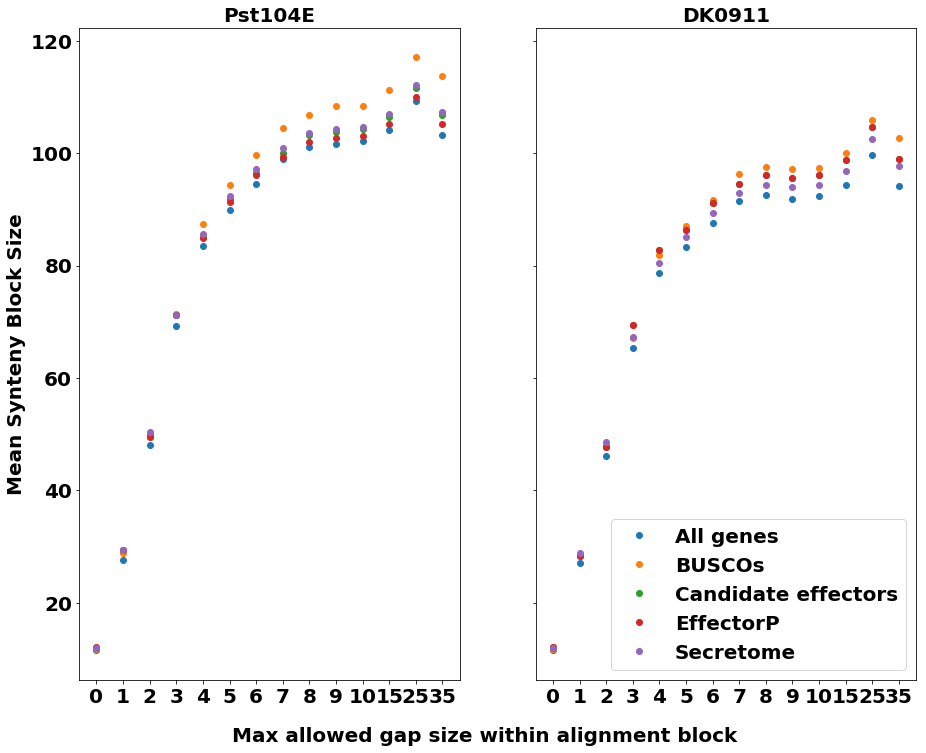

In [85]:
f, ax = plt.subplots(1,2, figsize=[15,12], sharey=True)

y= Max_collinear_mean['DK0911'].T.index


label_list = ["All genes", 'BUSCOs', 'Candidate effectors', 'EffectorP', 'Secretome']


for gene_type in gene_keys:
    ax[1].plot(y, Max_collinear_mean['DK0911'].T[gene_type], 'o')
    ax[1].title.set_text('DK0911')
    ax[1].title.set_size(font['size'])
    ax[1].title.set_weight(font['weight'])
    ax[1].title.set_family(font['family'])
    ax[0].title.set_text("Pst104E")
    ax[0].title.set_family(font['family'])
    ax[0].title.set_size(font['size'])
    ax[0].title.set_weight(font['weight'])
    ax[0].plot(y, Max_collinear_mean['Pst_104E'].T[gene_type], 'o')

f.text(0.5, 0.06, 'Max allowed gap size within alignment block', **font, ha='center', va='center')
ax[0].set_ylabel('Mean Synteny Block Size',**font)
L = plt.legend()
for label, pos in zip(label_list, range(0,len(label_list))):
    L.get_texts()[pos].set_text(label)

In [47]:
Max_collinear_median = {}
for genome in ['Pst_104E' , 'DK0911']:
    Max_collinear_median[genome] = {}
    for key, tmp_df in max_collinear_df_dict.items():
        if key.startswith(genome):
            m2_pattern = re.compile(r'_m([0-9]*)')
            m = re.findall(m2_pattern, key)[0]
            Max_collinear_median[genome][m] = get_genetype_median(tmp_df, genome, gene_keys)
    Max_collinear_median[genome] = max_colinear_df(Max_collinear_median[genome], gene_keys)  

/home/benjamin/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


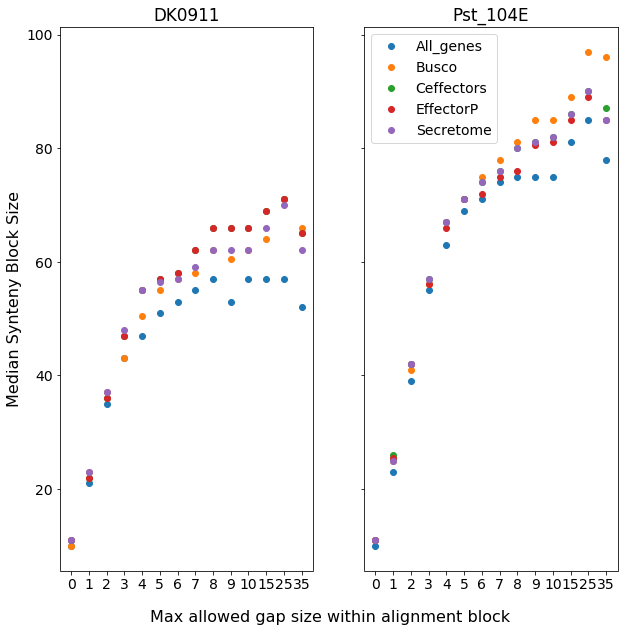

In [48]:
f, ax = plt.subplots(1,2, figsize=[10,10], sharey=True)



y= Max_collinear_median['DK0911'].T.index

for gene_type in gene_keys:
    ax[0].plot(y, Max_collinear_median['DK0911'].T[gene_type], 'o')
    ax[0].title.set_text('DK0911')
    ax[1].title.set_text("Pst_104E" )
    ax[1].plot(y,Max_collinear_median['Pst_104E'].T[gene_type], 'o')

f.text(0.5, 0.06, 'Max allowed gap size within alignment block', fontsize=16, ha='center', va='center')
ax[0].set_ylabel('Median Synteny Block Size',fontsize=16)
L = plt.legend()


In [49]:
Max_percentage = {}
for genome, genome_dict in zip(['Pst_104E' , 'DK0911'], [ Pst_104E_dict, DK0911_dict]):
    Max_percentage[genome] = {}
    for key, tmp_df in max_collinear_df_dict.items():
        if key.startswith(genome):
            m2_pattern = re.compile(r'_m([0-9]*)')
            m = re.findall(m2_pattern, key)[0]
            Max_percentage[genome][m] = get_genetype_percentage(tmp_df, genome, genome_dict,\
                                                                genome_dict['All_genes'],  gene_keys)
    Max_percentage[genome] = max_colinear_df(Max_percentage[genome], gene_keys)    

/home/benjamin/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


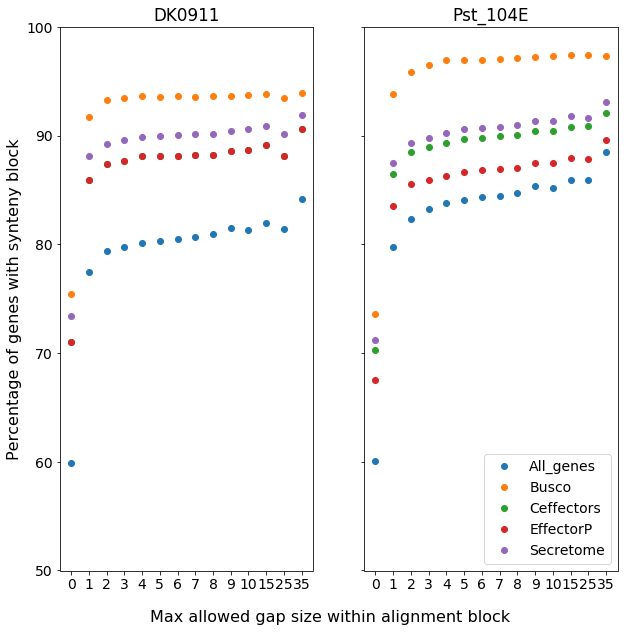

In [50]:
f, ax = plt.subplots(1,2, figsize=[10,10], sharey=True)



for gene_type in gene_keys:
    ax[0].plot(Max_percentage['DK0911'].T[gene_type],'o')
    ax[1].plot(Max_percentage['Pst_104E'].T[gene_type],'o')
    ax[0].title.set_text('DK0911')
    ax[1].title.set_text("Pst_104E" )

f.text(0.5, 0.06, 'Max allowed gap size within alignment block', fontsize=16, ha='center', va='center')
ax[0].set_ylabel('Percentage of genes with synteny block',fontsize=16)
ax[0].set_ylim(50,100)
plt.legend()

In [51]:
Max_collinear_mean_primary = {}
for genome, genome_dict in zip(['Pst_104E' , 'DK0911'], [Pst_104E_dict, DK0911_dict]):
    Max_collinear_mean_primary[genome] = {}
    
    for key, tmp_df in max_collinear_df_dict.items():
        tmp_df = tmp_df[tmp_df[genome].isin(get_gene_list(genome_dict["Primary_genes"]))].reset_index(drop=True).copy()
        
        if key.startswith(genome):
            m2_pattern = re.compile(r'_m([0-9]*)')
            m = re.findall(m2_pattern, key)[0]
            Max_collinear_mean_primary[genome][m] = get_genetype_means(tmp_df, genome, gene_keys)
    Max_collinear_mean_primary[genome] = max_colinear_df(Max_collinear_mean_primary[genome], gene_keys)    

### Figure 5 of the paper A

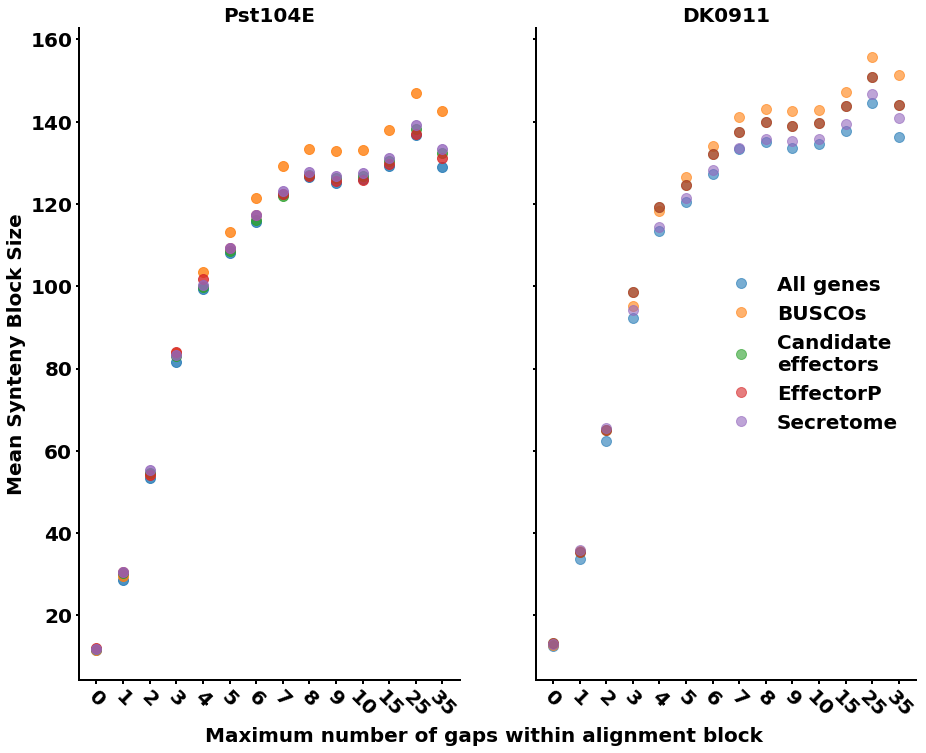

In [113]:
f, ax = plt.subplots(1,2, figsize=[15,12], sharey=True)

y= Max_collinear_mean_primary['DK0911'].T.index


label_list = ["All genes", 'BUSCOs', 'Candidate \neffectors', 'EffectorP', 'Secretome']


for gene_type in gene_keys:
    ax[1].plot(y, Max_collinear_mean_primary['DK0911'].T[gene_type], 'o', ms=10 ,alpha=0.6)
    ax[1].title.set_text('DK0911')
    ax[1].title.set_size(font['size'])
    ax[1].title.set_weight(font['weight'])
    ax[1].title.set_family(font['family'])
    ax[0].title.set_text("Pst104E")
    ax[0].title.set_family(font['family'])
    ax[0].title.set_size(font['size'])
    ax[0].title.set_weight(font['weight'])
    ax[0].plot(y, Max_collinear_mean_primary['Pst_104E'].T[gene_type], 'o', ms=10 ,alpha=0.8)

f.text(0.5, 0.06, 'Maximum number of gaps within alignment block', **font, ha='center', va='center')
ax[0].set_ylabel('Mean Synteny Block Size',**font)
L = plt.legend(frameon=False, loc=7)

for label, pos in zip(label_list, range(0,len(label_list))):
    L.get_texts()[pos].set_text(label)

for pos in range(0,2):
    for axis in ['bottom','left']:
        ax[pos].spines[axis].set_linewidth(2)
    for axis in ['top','right']:
        ax[pos].spines[axis].set_linewidth(0)
    ax[pos].tick_params(width=2)
    ax[pos].tick_params(axis='x',rotation=-45)

outfn = os.path.join(OUTPATH, 'F5A_synteny_block_length.tiff')
plt.savefig(outfn, dpi=600,bbox_inches='tight')

In [53]:
Max_percentage_primary = {}
for genome, bed_fn_dict in zip(['Pst_104E' , 'DK0911'], [ Pst_104E_dict, DK0911_dict]):
    Max_percentage_primary[genome] = {}
    for key, tmp_df in max_collinear_df_dict.items():
        tmp_df = tmp_df[tmp_df[genome].isin(get_gene_list(bed_fn_dict["Primary_genes"]))].reset_index(drop=True).copy()
        if key.startswith(genome):
            m2_pattern = re.compile(r'_m([0-9]*)')
            m = re.findall(m2_pattern, key)[0]
            Max_percentage_primary[genome][m] = get_genetype_percentage(tmp_df, genome, bed_fn_dict,\
                                                                        bed_fn_dict['Primary_genes'],  gene_keys)
    Max_percentage_primary[genome] = max_colinear_df(Max_percentage_primary[genome], gene_keys)

### Figure 5 of the paper B

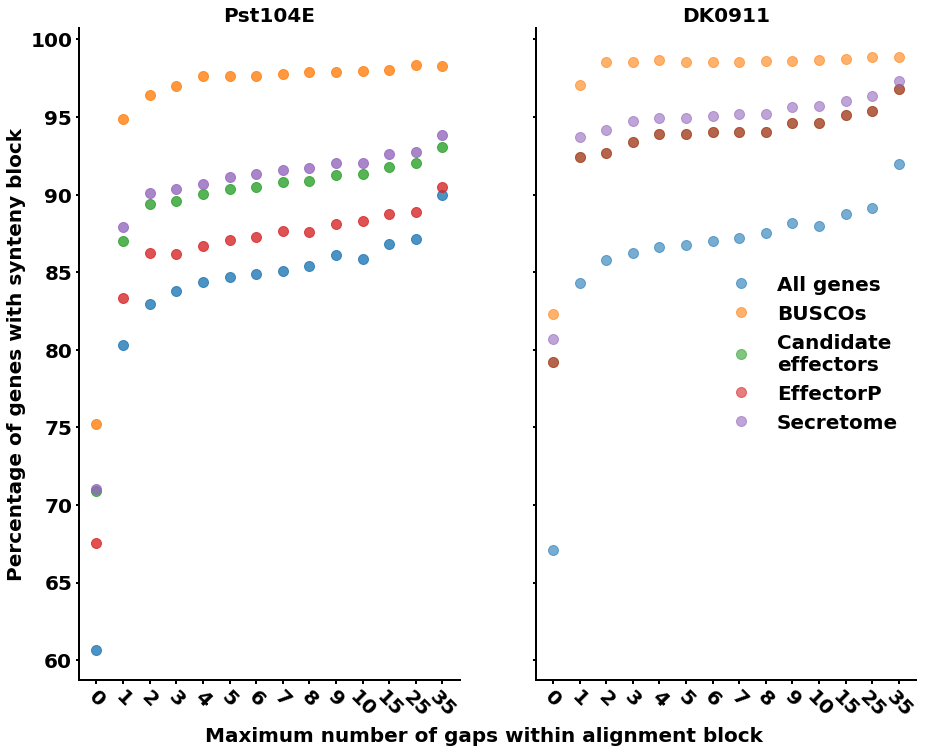

In [114]:
f, ax = plt.subplots(1,2, figsize=[15,12], sharey=True)

y= Max_percentage_primary['DK0911'].T.index


label_list = ["All genes", 'BUSCOs', 'Candidate \neffectors', 'EffectorP', 'Secretome']


for gene_type in gene_keys:
    ax[1].plot(y, Max_percentage_primary['DK0911'].T[gene_type], 'o', ms=10 ,alpha=0.6)
    ax[1].title.set_text('DK0911')
    ax[1].title.set_size(font['size'])
    ax[1].title.set_weight(font['weight'])
    ax[1].title.set_family(font['family'])
    ax[0].title.set_text("Pst104E")
    ax[0].title.set_family(font['family'])
    ax[0].title.set_size(font['size'])
    ax[0].title.set_weight(font['weight'])
    ax[0].plot(y, Max_percentage_primary['Pst_104E'].T[gene_type], 'o', ms=10 ,alpha=0.8)

f.text(0.5, 0.06, 'Maximum number of gaps within alignment block', **font, ha='center', va='center')
ax[0].set_ylabel('Percentage of genes with synteny block',**font)


L = plt.legend(frameon=False, loc=7)
for label, pos in zip(label_list, range(0,len(label_list))):
    L.get_texts()[pos].set_text(label)

    
for pos in range(0,2):
    for axis in ['bottom','left']:
        ax[pos].spines[axis].set_linewidth(2)
    for axis in ['top','right']:
        ax[pos].spines[axis].set_linewidth(0)
    ax[pos].tick_params(width=2)
    ax[pos].tick_params(axis='x',rotation=-45)
outfn = os.path.join(OUTPATH, 'F5B_synteny_gene_percentage.tiff')
plt.savefig(outfn, dpi=600,bbox_inches='tight')

### Analysis

Based on the plot above choose max allowed gap size of nine.

In [115]:
!ls /home/benjamin/genome_assembly/Warrior/DK0911_v04/comp_orthology/run_SynNet/

DiamondGenomesDB		     Genomes20190514_1307-SynNet-k25w0m9
DK.bed				     Genomes20190514_1324-SynNet-k25w0m10
DK.bed1				     Genomes20190514_1342-SynNet-k25w0m15
DK.pep				     Genomes20190514_1359-SynNet-k25w0m25
Genomes20190401_2103-SynNet-k0w0m25  Genomes20190514_1418-SynNet-k25w0m35
Genomes20190514_1016-SynNet-k25w0m0  Genomes20190529_1333-SynNet-k500w0m9
Genomes20190514_1036-SynNet-k25w0m1  PAu.bed
Genomes20190514_1054-SynNet-k25w0m2  PAu.bed1
Genomes20190514_1113-SynNet-k25w0m3  PAu.pep
Genomes20190514_1130-SynNet-k25w0m4  SynetBuilding-Diamond.sh
Genomes20190514_1149-SynNet-k25w0m5  SynetBuilding-post_Diamond.sh
Genomes20190514_1208-SynNet-k25w0m6  SynNet.sh
Genomes20190514_1227-SynNet-k25w0m7  test
Genomes20190514_1247-SynNet-k25w0m8


In [116]:
fn = '/home/benjamin/genome_assembly/Warrior/DK0911_v04/comp_orthology/run_SynNet/Genomes20190514_1247-SynNet-k25w0m8/DK_PAu.collinearity'

In [117]:
syn_df = get_collinear_df(fn)
gene_keys = ['All_genes','Busco', 'Ceffectors',  'EffectorP',   'Secretome']

for genome, bed_fn_dict in zip(['DK0911', 'Pst_104E'], [DK0911_dict, Pst_104E_dict]):
    syn_df = add_gentype_column(syn_df, gene_keys, genome, bed_fn_dict)

In [119]:
syn_df.head()

,DK0911,Pst_104E,aln_length,aln_name,aln_position,distance_3,distance_5,DK0911_All_genes,DK0911_Busco,DK0911_Ceffectors,DK0911_EffectorP,DK0911_Secretome,Pst_104E_All_genes,Pst_104E_Busco,Pst_104E_Ceffectors,Pst_104E_EffectorP,Pst_104E_Secretome
0,DK0911_00336,Pst104E_18142,6,Alignment 0,0,6,0,True,False,False,False,False,True,False,False,False,False
1,DK0911_00337,Pst104E_18143,6,Alignment 0,1,5,1,True,False,False,False,False,True,False,False,False,False
2,DK0911_00338,Pst104E_18144,6,Alignment 0,2,4,2,True,False,False,False,False,True,False,False,False,False
3,DK0911_00339,Pst104E_18145,6,Alignment 0,3,3,3,True,False,False,False,False,True,False,False,False,False
4,DK0911_00340,Pst104E_18146,6,Alignment 0,4,2,4,True,False,False,False,False,True,False,False,False,False


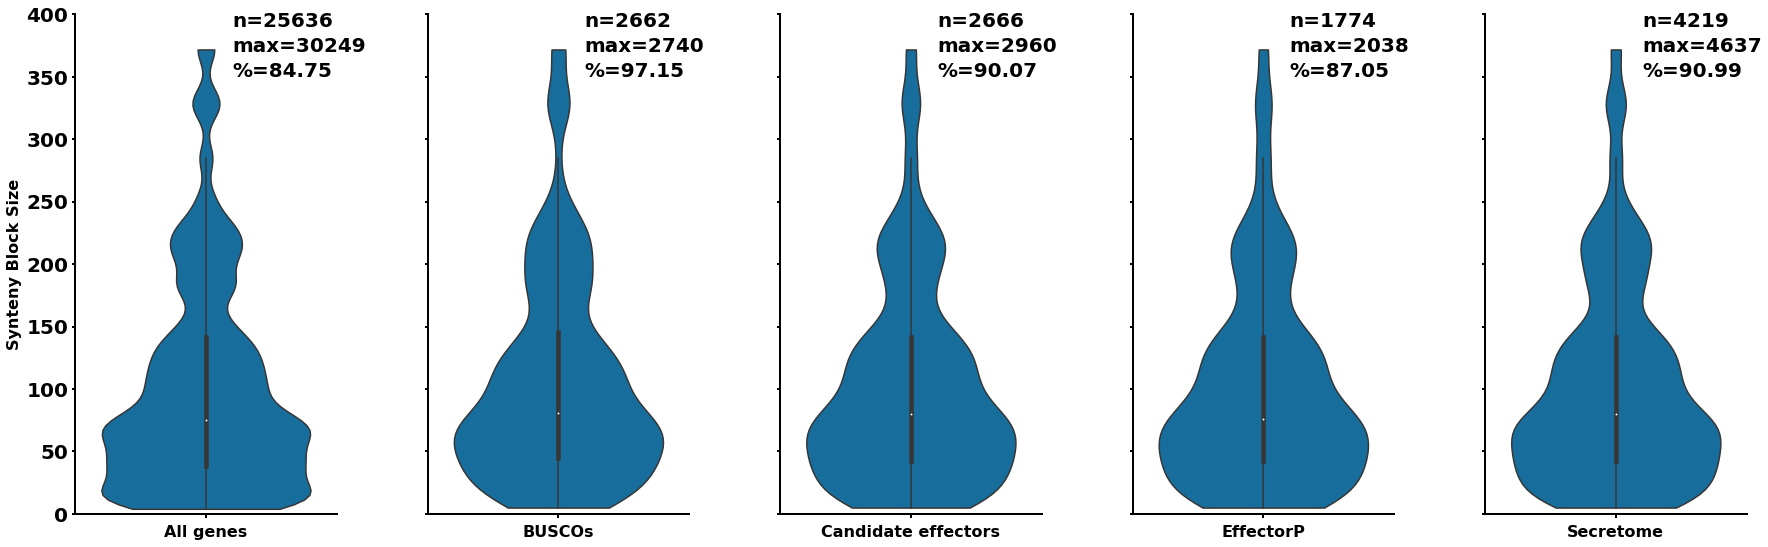

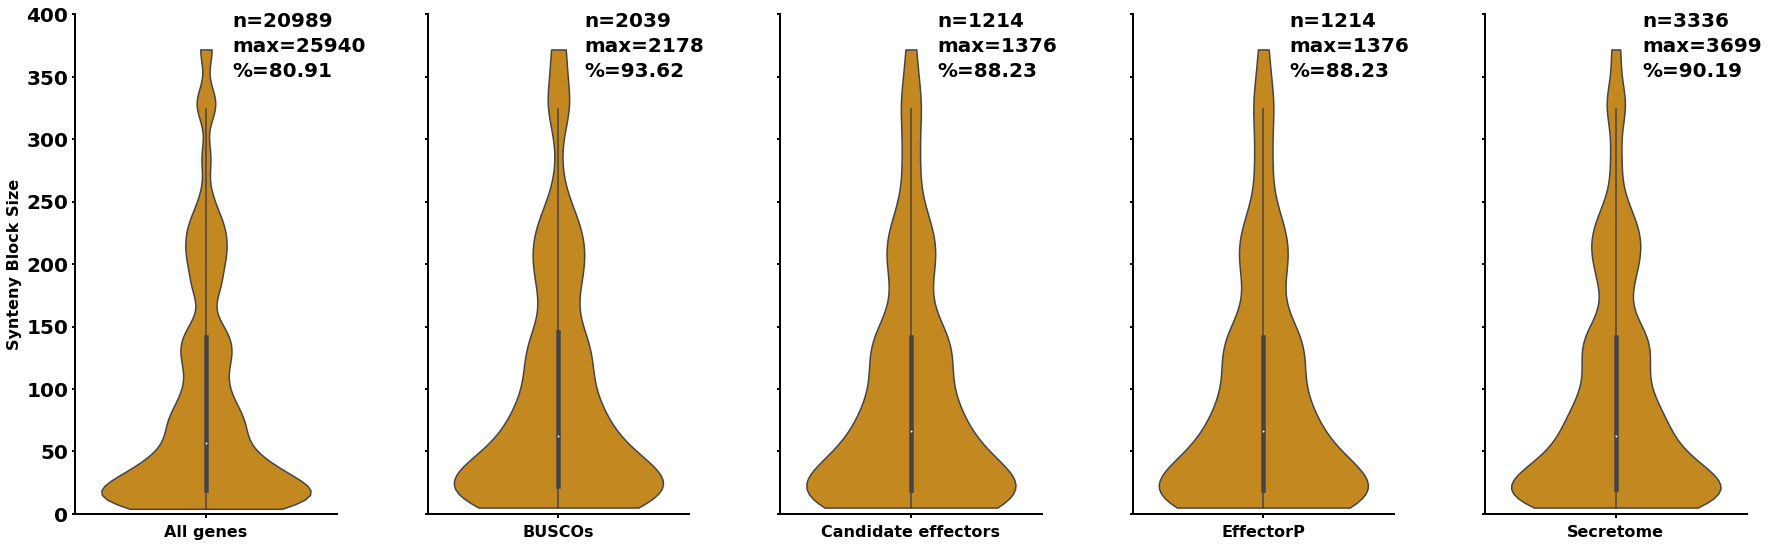

In [122]:
max_length_df_dict = {}
pallete = [sns.color_palette('colorblind')[x] for x in [0,1]]
for genome, color, genome_dict in zip(['Pst_104E', 'DK0911'], pallete, [Pst_104E_dict, DK0911_dict]): 
    idx = syn_df.groupby(genome)['aln_length'].agg(pd.Series.idxmax)
    max_length_df_dict[genome] = syn_df.iloc[idx].drop_duplicates([genome, 'aln_length']).copy()
    for gene_type in syn_df.columns[-10:]:
        if genome in gene_type:
            _tmp_df = max_length_df_dict[genome]
      
            #print(genome, gene_type)
            #print(round(_tmp_df[_tmp_df[gene_type] == True]['aln_length'].mean(),2))
            #print(round(_tmp_df[_tmp_df[gene_type] == True]['aln_length'].median(),2))
    plot_synteny(genome, max_length_df_dict[genome],genome_dict["All_genes"],   color, 'something')

Pst_104E Pst_104E_All_genes
126.51 100.0
Pst_104E Pst_104E_Busco
133.39 111.0
Pst_104E Pst_104E_Ceffectors
127.13 102.0
Pst_104E Pst_104E_EffectorP
126.85 111.0
Pst_104E Pst_104E_Secretome
127.89 102.0
DK0911 DK0911_All_genes
134.97 116.0
DK0911 DK0911_Busco
143.0 125.0
DK0911 DK0911_Ceffectors
139.9 125.0
DK0911 DK0911_EffectorP
139.9 125.0
DK0911 DK0911_Secretome
135.91 117.0


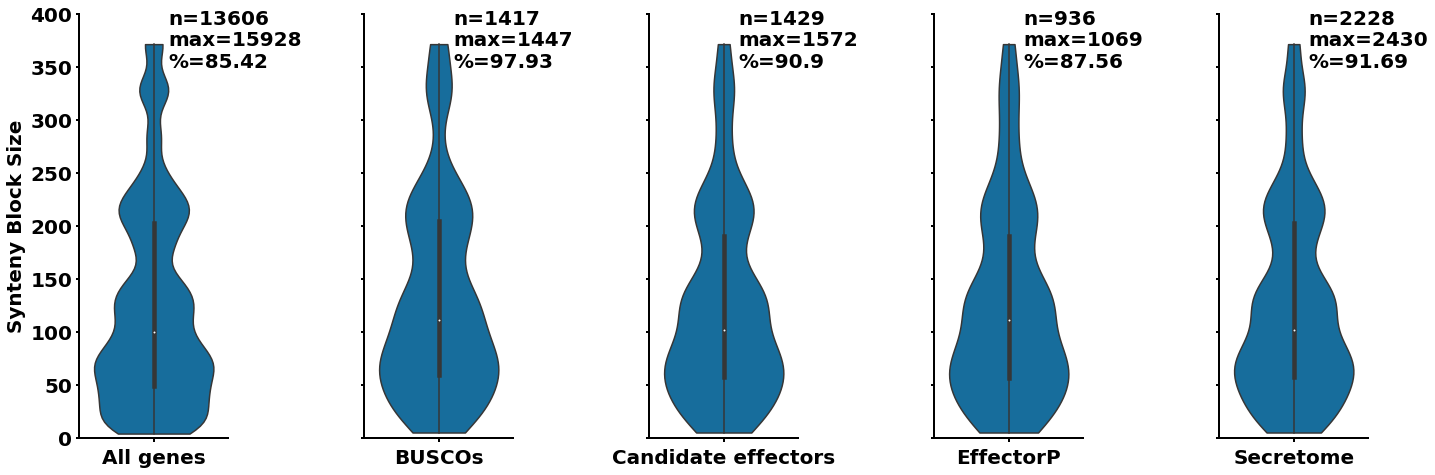

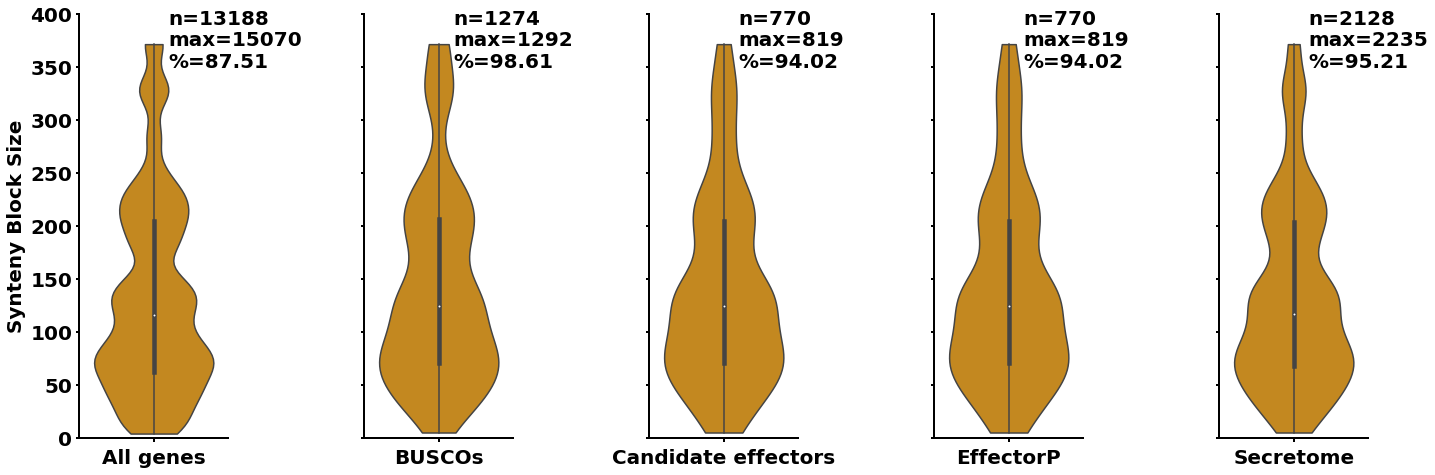

In [126]:
max_length_df_dict = {}
pallete = [sns.color_palette('colorblind')[x] for x in [0,1]]
for genome, color, genome_dict in zip(['Pst_104E', 'DK0911'], pallete, [Pst_104E_dict, DK0911_dict]): 
    idx = syn_df.groupby(genome)['aln_length'].agg(pd.Series.idxmax)
    max_length_df_dict[genome] = syn_df.iloc[idx].drop_duplicates([genome, 'aln_length']).copy()
    for gene_type in syn_df.columns[-10:]:
        if genome in gene_type:
            _tmp_df = max_length_df_dict[genome]
            sub_gene_list = get_gene_list(genome_dict["Primary_genes"])
            _tmp_df = _tmp_df[_tmp_df[genome].isin(sub_gene_list)].copy()
            _tmp_df = _tmp_df.reset_index(drop=True)
            print(genome, gene_type)
            print(round(_tmp_df[_tmp_df[gene_type] == True]['aln_length'].mean(),2),\
                  round(_tmp_df[_tmp_df[gene_type] == True]['aln_length'].median(),2))
    plot_synteny(genome,_tmp_df,genome_dict["Primary_genes"],   color, 'something')
    outfn = os.path.join(OUTPATH, 'SF7_%s_synteny_block_size_per_gene_group.tiff' % genome)
    plt.savefig(outfn, dpi=600,bbox_inches='tight')

In [59]:
max_length_df_dict['Pst_104E']

,DK0911,Pst_104E,aln_length,aln_name,aln_position,distance_3,distance_5,DK0911_All_genes,DK0911_Busco,DK0911_Ceffectors,DK0911_EffectorP,DK0911_Secretome,Pst_104E_All_genes,Pst_104E_Busco,Pst_104E_Ceffectors,Pst_104E_EffectorP,Pst_104E_Secretome
26229,DK0911_15056,Pst104E_00000,115,Alignment 1313,0,115,0,True,False,False,False,False,True,False,False,False,False
26230,DK0911_15057,Pst104E_00001,115,Alignment 1313,1,114,1,True,False,False,False,True,True,False,False,False,True
26231,DK0911_15058,Pst104E_00002,115,Alignment 1313,2,113,2,True,False,True,True,True,True,False,True,True,True
26232,DK0911_15059,Pst104E_00003,115,Alignment 1313,3,112,3,True,False,False,False,True,True,False,False,False,True
26233,DK0911_15060,Pst104E_00004,115,Alignment 1313,4,111,4,True,False,False,False,False,True,False,False,False,False
26234,DK0911_15061,Pst104E_00005,115,Alignment 1313,5,110,5,True,False,False,False,True,True,False,True,False,True
26235,DK0911_15062,Pst104E_00007,115,Alignment 1313,6,109,6,True,False,False,False,False,True,False,False,False,False
26236,DK0911_15063,Pst104E_00008,115,Alignment 1313,7,108,7,True,False,True,True,True,True,False,True,True,True
26237,DK0911_15064,Pst104E_00009,115,Alignment 1313,8,107,8,True,False,False,False,True,True,False,False,False,False
26238,DK0911_15068,Pst104E_00010,115,Alignment 1313,9,106,9,True,True,False,False,False,True,True,False,False,False


### Now fish out the best hits

First get all the best hits based on the synteny

sny_df groupby genome pull out genome number ask which one is in the best hit in the blast pair up.

In [60]:
syn_folder = '/home/benjamin/genome_assembly/Warrior/DK0911_v04/comp_orthology/run_SynNet/Genomes20190529_1333-SynNet-k500w0m9//'
syn_df_fn = os.path.join(syn_folder, 'DK_PAu.collinearity')
Diamond_df_dict = {}
DK0911_diamond_fn = os.path.join(syn_folder, 'DK_PAu')
Pst_104E_diamond_fn = os.path.join(syn_folder, 'PAu_DK')
DK0911_pairing_fn = os.path.join(syn_folder, 'DK.pairing')
Pst_104E_pairing_fn = os.path.join(syn_folder, 'PAu.pairing')

DK0911_orthopairing_fn = os.path.join(syn_folder, 'DK.orthopairing')
Pst_104E_orthopairing_fn = os.path.join(syn_folder, 'PAu.orthopairing')

DK0911_nopairing_fn = os.path.join(syn_folder, 'DK.nopairing')
Pst_104E_nopairing_fn = os.path.join(syn_folder, 'PAu.nopairing')
syn_df = get_collinear_df(syn_df_fn)
Diamond_df_dict['DK0911'] = get_diamond_six_df(DK0911_diamond_fn)
Diamond_df_dict['Pst_104E'] = get_diamond_six_df(Pst_104E_diamond_fn)

In [ ]:
def get_best_blast_hit(query, subject, blast_df):
    if len(blast_df[(blast_df['qseqid'] == query) & (blast_df['sseqid'].isin(subject))]) > 0:
        idx = blast_df[(blast_df['qseqid'] == query) & (blast_df['sseqid'].isin(subject))]['bitscore'].idxmax()
        return str(blast_df.loc[idx,'qseqid']), str(blast_df.loc[idx, 'sseqid'])
    else:
        return '',''

In [ ]:
#group by the query genome and loop of the groups
#input the alignment hits into the get_best_blast_hit function
#this function returns the best match
Done_gene_list = {}
Funn_gene_list = {}

for q_genome, s_genome, out_fn in \
zip(['DK0911', 'Pst_104E'], ['Pst_104E', 'DK0911'], [DK0911_pairing_fn, Pst_104E_pairing_fn]):
    grouped = syn_df.groupby(q_genome)
    Done_gene_list[q_genome] = []
    Funn_gene_list[q_genome] = []
    with open(out_fn,'w') as out_hn:
        for name, group in grouped:
            #print(name)
            query, subject = get_best_blast_hit(str(name), group[s_genome].tolist(), Diamond_df_dict[q_genome])
            if query != '':
                Done_gene_list[q_genome].append(query)
                print(query, subject, sep='\t', file = out_hn)
            elif query == '':
                Funn_gene_list[q_genome].append(name)
#next fish out all the not done pairing and get those from the orthology analysis in a similar manner

In [ ]:
for key, value in Funn_gene_list.items():
    print('%s: %s' %(key, len(value)))

In [ ]:
#now save out all the genes without paring
for genome, genome_dict, out_fn in zip(['DK0911', 'Pst_104E'], [DK0911_dict, Pst_104E_dict],\
                                       [DK0911_nopairing_fn, Pst_104E_nopairing_fn]):
    nopairing_genes = set(get_gene_list(genome_dict['All_genes'])) - set(Done_gene_list[genome])
    with open(out_fn, 'w') as out_hn:
        for gene in nopairing_genes:
            print(gene, file=out_hn)

In [ ]:
#get the orthofinder results read in
#this is the dict for all orthogroups and what members they have
orthofinder_dict = get_ortho_dict(ORTHOFINDER_FILE_NAME)
#this is the dict for proteins and what orthogroup they have
gene_to_ortho_dict = get_gene_to_ortho_dict(orthofinder_dict)

In [ ]:
No_match_dict = {}
No_blast_match = {}
Done_gene_list_ortho = {}
for genome, genome_dict, target, out_fn in zip(['DK0911', 'Pst_104E'], [DK0911_dict, Pst_104E_dict], \
                                       ['Pst104E', 'DK0911'], [DK0911_orthopairing_fn, Pst_104E_orthopairing_fn]):
    nopairing_genes = set(get_gene_list(genome_dict['All_genes'])) - set(Done_gene_list[genome])
    No_match_dict[genome] = []
    No_blast_match[genome] = []
    Done_gene_list_ortho[genome] = []
    with open(out_fn, 'w') as out_hn:
        
        for gene in nopairing_genes:
            ortho_group = gene_to_ortho_dict[gene]
            ortho_match = [x for x in orthofinder_dict[ortho_group] if x.startswith(target)]
            if len(ortho_match) > 0:
                query, subject = get_best_blast_hit(gene, ortho_match, Diamond_df_dict[genome])
                if query != '':
                    Done_gene_list_ortho[genome].append(query)
                    print(query, subject, sep='\t', file = out_hn)
                elif query == '':
                    No_blast_match[genome].append(gene)
            elif len(ortho_match) == 0:
                No_match_dict[genome].append(gene)

In [ ]:
for key, value in No_blast_match.items():
    print('%s: %s' %(key, len(value)))

In [69]:
for key, value in No_match_dict.items():
    print('%s: %s' %(key, len(value)))

Pst_104E: 1118
DK0911: 1021


### Comment
Initially this was run with Genomes20190514_1307-SynNet-k25w0m9, but I ran the same parameters but changing the k value for the blast search to 500 to get better coverage in hits. 

I hope this will reduce the 
for key, value in Funn_gene_list.items():
    print('%s: %s' %(key, len(value)))
    
DK0911: 93
Pst_104E: 50

and

for key, value in No_blast_match.items():
    print('%s: %s' %(key, len(value)))

DK0911: 200
Pst_104E: 174